In [2]:
import numpy as np
np.random.seed(1) # for reproducibility

import keras.backend as K
import tensorflow as tf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import pickle
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import Huber
# from tensorflow.keras import optimizers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

2024-11-23 19:46:02.594007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 19:46:02.594378: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 19:46:02.596372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 19:46:02.602897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 19:46:02.613056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
df = pd.read_csv("Dataset/AEP_hourly.csv")

In [4]:
df = df[['AEP_MW']]

In [5]:
df.head()

,AEP_MW
0,13478.0
1,12865.0
2,12577.0
3,12517.0
4,12670.0


In [6]:
df.shape

(121273, 1)

In [7]:
def create_data(dataset,window_size = 10):
    # df = dataset.to_numpy()
    df = dataset.copy()
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [a for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
        
    return np.array(X),np.array(y)

In [8]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [10]:
WINDOW_SIZE = 10

X,y = create_data(data_scaled,WINDOW_SIZE)

In [11]:
X.shape

(121263, 10, 1)

In [12]:
y.shape

(121263, 1)

In [13]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
model_mse = Sequential()
model_mse.add(InputLayer(shape = (10,1)))
model_mse.add(LSTM(128,return_sequences=True))
model_mse.add(LSTM(32))
model_mse.add(Dense(8,'relu'))
model_mse.add(Dense(1,'linear'))

# model_mse.summary()
model_mse.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
# history_mse = model_mse.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,callbacks=[cp])
history_mse = model_mse.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0050 - root_mean_squared_error: 0.0646 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 2/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 8.6190e-04 - root_mean_squared_error: 0.0294 - val_loss: 7.7439e-04 - val_root_mean_squared_error: 0.0278
Epoch 3/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 7.6778e-04 - root_mean_squared_error: 0.0277 - val_loss: 6.8888e-04 - val_root_mean_squared_error: 0.0262
Epoch 4/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 7.0758e-04 - root_mean_squared_error: 0.0266 - val_loss: 6.5559e-04 - val_root_mean_squared_error: 0.0256
Epoch 5/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 6.3758e-04 - root_mean_squared_error: 0.0252 - val_loss: 7.0842e-04 - val_root_mean_squared_error: 0.0266
Epoch 6/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 6.0622e-04 - root_mean_squared_error: 0.0246 - val_loss: 6.1636e-04 - val_root_mean_squared_error: 0

In [19]:
model_mae = Sequential()
model_mae.add(InputLayer(shape = (10,1)))
model_mae.add(LSTM(128,return_sequences=True))
model_mae.add(LSTM(32))

model_mae.add(Dense(8,'relu'))
model_mae.add(Dense(1,'linear'))

# model_mae.summary()
# cp = model_maeCheckpoint('output/best_model.weights.h5',save_weights_only=False)
# cp = model_maeCheckpoint('output/best_model.keras',save_weights_only=False)
model_mae.compile(loss='mae',optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
history_mae = model_mae.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0487 - root_mean_squared_error: 0.0765 - val_loss: 0.0185 - val_root_mean_squared_error: 0.0294
Epoch 2/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0185 - root_mean_squared_error: 0.0286 - val_loss: 0.0168 - val_root_mean_squared_error: 0.0268
Epoch 3/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.0166 - root_mean_squared_error: 0.0265 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0261
Epoch 4/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.0155 - root_mean_squared_error: 0.0252 - val_loss: 0.0159 - val_root_mean_squared_error: 0.0258
Epoch 5/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0152 - root_mean_squared_error: 0.0250 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0251
Epoch 6/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.0149 - root_mean_squared_error: 0.0249 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0244
Epoch 7/10
3032/3032 ━━━━━━━━━━━━━

In [35]:
model_huber = Sequential()
model_huber.add(InputLayer(shape = (10,1)))
model_huber.add(LSTM(128,return_sequences=True))
model_huber.add(LSTM(32))

model_huber.add(Dense(8,'relu'))
model_huber.add(Dense(1,'linear'))

model_huber.compile(loss='Huber',optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
# model_huber.compile(loss=huber_loss,optimizer=Adam(learning_rate=0.0001),metrics = ['accuracy'])

history_huber = model_huber.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 64s 20ms/step - loss: 0.0048 - root_mean_squared_error: 0.0873 - val_loss: 4.3502e-04 - val_root_mean_squared_error: 0.0295
Epoch 2/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 63s 21ms/step - loss: 4.3749e-04 - root_mean_squared_error: 0.0296 - val_loss: 3.9306e-04 - val_root_mean_squared_error: 0.0280
Epoch 3/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - loss: 3.7714e-04 - root_mean_squared_error: 0.0275 - val_loss: 3.6301e-04 - val_root_mean_squared_error: 0.0269
Epoch 4/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - loss: 3.4090e-04 - root_mean_squared_error: 0.0261 - val_loss: 3.2877e-04 - val_root_mean_squared_error: 0.0256
Epoch 5/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - loss: 3.1464e-04 - root_mean_squared_error: 0.0251 - val_loss: 3.6070e-04 - val_root_mean_squared_error: 0.0269
Epoch 6/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - loss: 3.2129e-04 - root_mean_squared_error: 0.0253 - val_loss: 3.1738e-04 - val_root_mean_square

In [ ]:
import tensorflow as tf
import keras.backend as K
def custom_loss(y_true, y_pred):
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
    
    y_true_move = tf.cast(tf.greater_equal(y_true_diff, 0), tf.float32)
    y_pred_move = tf.cast(tf.greater_equal(y_pred_diff, 0), tf.float32)
    
    direction_mismatch = tf.not_equal(y_true_move, y_pred_move)
    
    penalty_factor = tf.reduce_mean(tf.abs(y_true_diff)) 
    penalty = tf.where(direction_mismatch, 
                       (tf.abs(y_true_diff - y_pred_diff) * penalty_factor), 
                       tf.zeros_like(y_true_diff))   
    # Mean squared error loss
    # mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    
    custom_loss = mse_loss + penalty
    
    return custom_loss

In [ ]:
model_custom = Sequential()
model_custom.add(InputLayer(shape = (10,1)))
model_custom.add(LSTM(128,return_sequences=True))
model_custom.add(LSTM(32))

model_custom.add(Dense(8,'relu'))
model_custom.add(Dense(1,'linear'))

model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
# model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.0001),metrics = ['accuracy'])

history_custom = model_custom.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 61s 19ms/step - loss: 0.0056 - root_mean_squared_error: 0.0576 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0296
Epoch 2/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - loss: 0.0012 - root_mean_squared_error: 0.0274 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0267
Epoch 3/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - loss: 0.0011 - root_mean_squared_error: 0.0260 - val_loss: 9.9080e-04 - val_root_mean_squared_error: 0.0246
Epoch 4/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - loss: 9.9896e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0250
Epoch 5/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - loss: 9.3595e-04 - root_mean_squared_error: 0.0243 - val_loss: 9.6645e-04 - val_root_mean_squared_error: 0.0244
Epoch 6/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - loss: 9.4824e-04 - root_mean_squared_error: 0.0245 - val_loss: 9.1155e-04 - val_root_mean_squared_error: 0.0235
Epoc

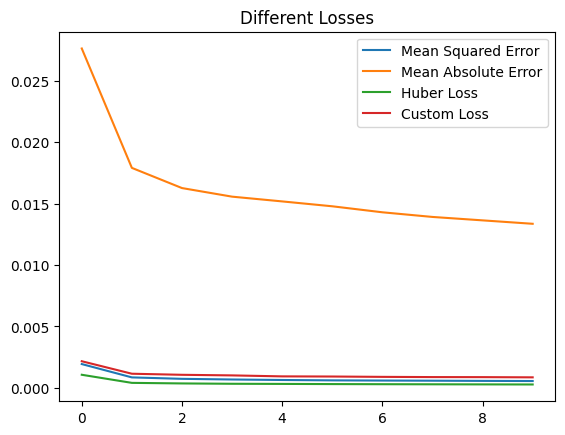

In [32]:
plt.plot(history_mse.history['loss'],label = 'Mean Squared Error')
plt.plot(history_mae.history['loss'],label = 'Mean Absolute Error')
plt.plot(history_huber.history['loss'],label = 'Huber Loss')
plt.plot(history_custom.history['loss'],label = 'Custom Loss')
plt.gca().set_xscale('linear')
plt.title('Different Losses')
plt.legend()
plt.show()

In [36]:
train_predictions_mse = model_mse.predict(X_train).flatten()
train_predictions_mae = model_mae.predict(X_train).flatten()
train_predictions_custom = model_custom.predict(X_train).flatten()
train_predictions_huber = model_huber.predict(X_train).flatten()

test_predictions_mse= model_mse.predict(X_test).flatten()
test_predictions_mae= model_mae.predict(X_test).flatten()
test_predictions_custom= model_custom.predict(X_test).flatten()
test_predictions_huber = model_huber.predict(X_test).flatten()

3032/3032 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
758/758 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step


In [41]:
huber_loss = tf.keras.losses.Huber(delta=1.0)  # delta is the threshold for transition between quadratic and linear loss

print("MSE model " ,mean_absolute_error(Y_train,train_predictions_mse))
print("MAE model " ,mean_absolute_error(Y_train,train_predictions_mae))
print("Huber model " ,mean_absolute_error(Y_train,train_predictions_huber))
print("Custom model " ,mean_absolute_error(Y_train,train_predictions_custom))
print()

print("MSE model " ,mean_squared_error(Y_train,train_predictions_mse))
print("MAE model " ,mean_squared_error(Y_train,train_predictions_mae))
print("Huber model " ,mean_squared_error(Y_train,train_predictions_huber))
print("Custom model " ,mean_squared_error(Y_train,train_predictions_custom))
print()

print("MSE model " ,huber_loss(Y_train,train_predictions_mse))
print("MAE model " ,huber_loss(Y_train,train_predictions_mae))
print("Huber model " ,huber_loss(Y_train,train_predictions_huber))
print("Custom model " ,huber_loss(Y_train,train_predictions_custom))

MSE model  0.014632605284394501
MAE model  0.01369014291845786
Huber model  0.013884653343846212
Custom model  0.01659073521569804

MSE model  0.000567330911176765
MAE model  0.0005479341058078367
Huber model  0.0005191193468417387
Custom model  0.0006207768435139674

MSE model  tf.Tensor(0.00028366546, shape=(), dtype=float32)
MAE model  tf.Tensor(0.00027396707, shape=(), dtype=float32)
Huber model  tf.Tensor(0.00025955966, shape=(), dtype=float32)
Custom model  tf.Tensor(0.00031038842, shape=(), dtype=float32)


In [ ]:
print("MSE model " ,mean_absolute_error(Y_test,test_predictions_mse))
print("MAE model " ,mean_absolute_error(Y_test,test_predictions_mae))
print("Huber model " ,mean_absolute_error(Y_test,test_predictions_huber))
print("Custom model " ,mean_absolute_error(Y_test,test_predictions_custom))
print()

print("MSE model " ,mean_squared_error(Y_test,test_predictions_mse))
print("MAE model " ,mean_squared_error(Y_test,test_predictions_mae))
print("Huber model " ,mean_squared_error(Y_test,test_predictions_huber))
print("Custom model " ,mean_squared_error(Y_test,test_predictions_custom))
print()

print("MSE model " ,huber_loss(Y_test,test_predictions_mse))
print("MAE model " ,huber_loss(Y_test,test_predictions_mae))
print("Huber model " ,huber_loss(Y_test,test_predictions_huber))
print("Custom model " ,huber_loss(Y_test,test_predictions_custom))

MSE model  0.014755380072022796
MAE model  0.013831377782865372
Huber model  0.01394514537852135
Custom model  0.016664370426480314

MSE model  0.0005981877091571154
MAE model  0.0005790944016802323
Huber model  0.0005481074485495504
Custom model  0.000650927784290348

MSE model  tf.Tensor(0.00029909384, shape=(), dtype=float32)
MAE model  tf.Tensor(0.0002895472, shape=(), dtype=float32)
Huber model  tf.Tensor(0.00027405372, shape=(), dtype=float32)
Custom model  tf.Tensor(0.0003254639, shape=(), dtype=float32)


In [43]:
print("MSE model " ,r2_score(Y_test,test_predictions_mse))
print("MAE model " ,r2_score(Y_test,test_predictions_mae))
print("Huber model " ,r2_score(Y_test,test_predictions_huber))
print("Custom model " ,r2_score(Y_test,test_predictions_custom))

MSE model  0.9767582217882185
MAE model  0.9775000665485067
Huber model  0.978704022900497
Custom model  0.9747090771629527


In [44]:
print("MSE model " ,r2_score(Y_train,train_predictions_mse))
print("MAE model " ,r2_score(Y_train,train_predictions_mae))
print("Huber model " ,r2_score(Y_train,train_predictions_huber))
print("Custom model " ,r2_score(Y_train,train_predictions_custom))

MSE model  0.9780895977079216
MAE model  0.978838705151993
Huber model  0.9799515353335655
Custom model  0.976025508028841
